# Development notebook for processing sexual dimorphism data
## This notebook takes as input the csv produced from 'sample_reader_nb', which represents the load and rearranged sexual dimorphism data matrix

In [1]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

### 1. Read in meta data and big data file, create meta_data_df, and remove cntnp strain

In [2]:
meta_data_df, df, df_bool = dp.load_data(metadata_file = '/bigdata/isaac/meta_data_dict_040224.json', 
                                                         bigdata_file = '/bigdata/isaac/dimorph_df.feather')

In [3]:
df.shape

(27933, 79613)

In [4]:
meta_data_df.shape

(27, 79613)

In [5]:
meta_data_df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
Serial_Number,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
Date_Captured,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,...,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,...,,,,,,,,,,


populate metadata with following row indices, intialize values as None

In [6]:
## intialize all the upcoming processsing steps as none in processing status df
## update at each step in metadata) and boolean write to file for each processing step for metadatadf and gene expression df

In [7]:
steps = ['cell_exclusion (l1)',
         'gene_exclusion (l1)',
         'get_top_cv_genes',
         'log_and_standerdize',
         'analyze_pca',
         'get_perplexity',
         'do_tsne']
status_df = pd.DataFrame(columns =['completion_status'], 
                        index = steps)
status_df

,completion_status
cell_exclusion (l1),NaN
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


In [8]:
#status_df.loc['l1_cell_exclusion',:] = True

In [9]:
status_df

,completion_status
cell_exclusion (l1),NaN
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


### 2. Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [10]:
df, df_bool, meta_data_df, status_df = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      meta_data_df = meta_data_df,
                                                      df_bool = df_bool,
                                                      df = df,
                                                      status_df = status_df)


Total cells reduced from 79613 to 43492


In [11]:
df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [12]:
df.shape

(27933, 43492)

In [13]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


#### Sanity Check of known specific sex genes

In [14]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

True
True
True
True
True
True


num m cells: 19749 num f cells: 23743


<IPython.core.display.Javascript object>


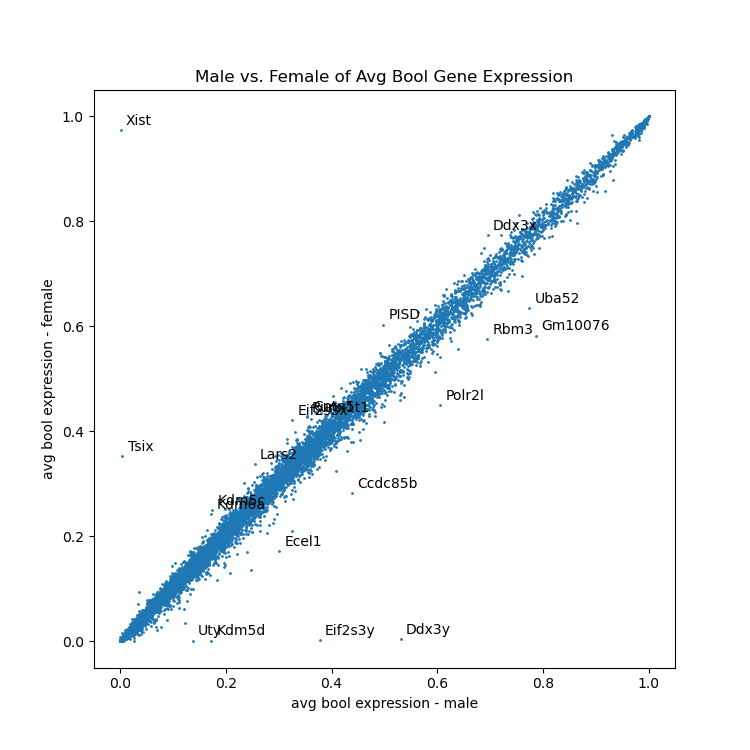

In [15]:
%matplotlib notebook
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = df_bool,
                                                              meta_data_df=meta_data_df,
                                                             num_top_genes=10,
                                                             plot_flag=1)

### 3. Gene Exclusion - Keep only genes expressed in >10 cells, <50% of all cells

In [16]:
df, df_bool, meta_data_df, status_df = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=df_bool,
                                                     df = df,
                                                     meta_data_df = meta_data_df,
                                                     status_df = status_df)
df.head()

Total genes reduced from 27933 to 17081


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [17]:
df.shape

(17081, 43492)

In [18]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


#### Sanity Check of known specific sex genes

In [19]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

False
True
True
True
True
True


### 4. CV vs. Mean (Poisson filter)

<IPython.core.display.Javascript object>


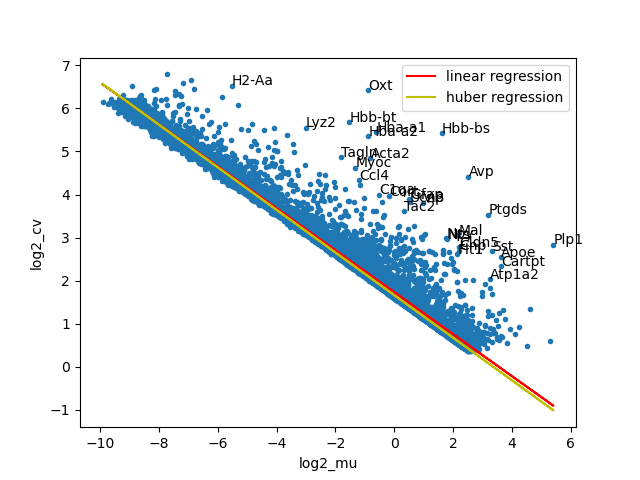

In [20]:
cv_df = dp.analyze_cv(df = df,
                      norm_scale_factor=20000,
                      num_top_genes=30,
                      plot_flag=1,
                     use_huber = True)

In [21]:
cv_df.head()

,log2mu,log2cv,delta_cv
gene,,,
Hbb-bs,1.620289,5.429946,4.570352
Oxt,-0.879842,6.428204,4.330631
Avp,2.526425,4.414903,4.003995
Plp1,5.415903,2.831623,3.851485
Hba-a1,-0.615138,5.448019,3.481519


In [22]:
cv_df.shape

(17081, 3)

#### knee plot

<IPython.core.display.Javascript object>


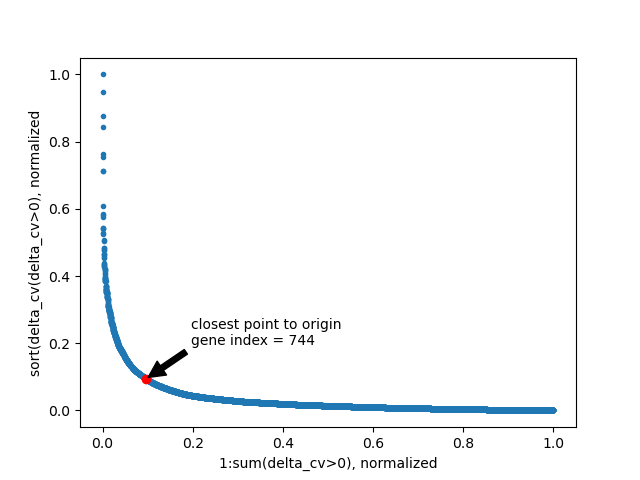

In [23]:
gene_index, df, status_df = dp.get_top_cv_genes(df = df, cv_df=cv_df, plot_flag=1, status_df=status_df)

In [24]:
df.shape

(744, 43492)

In [25]:
gene_index

744

In [26]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


##### Feature selection 
utilize mean-variance relationship (PCA). Why this as opposed t mean-dropout relationship? see 'feature selection' section in :
https://www.nature.com/articles/s41467-019-13056-x

In [27]:
df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oxt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avp,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plp1,0,0,2,0,0,0,1,0,0,0,...,1,0,0,1,0,71,0,0,0,1
Hba-a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
log_std_arr,status_df = dp.log_and_standerdize_df(df,status_df)

row mean after standardization: 0.00
row sigma after standardization: 1.00


In [29]:
log_std_arr.shape

(43492, 744)

In [30]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


PCA with num components = all genes 

<IPython.core.display.Javascript object>


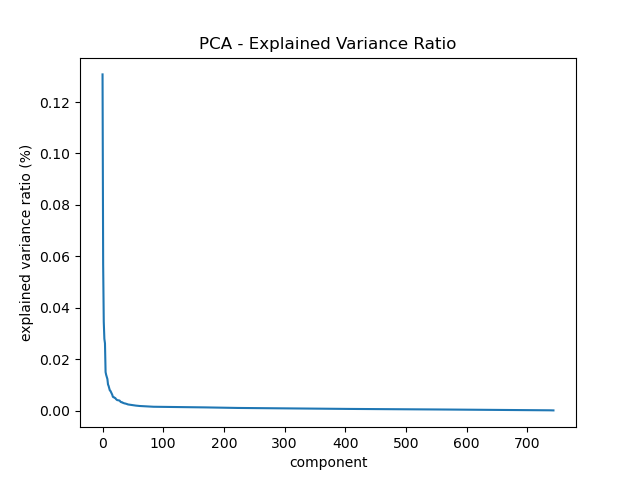

<IPython.core.display.Javascript object>


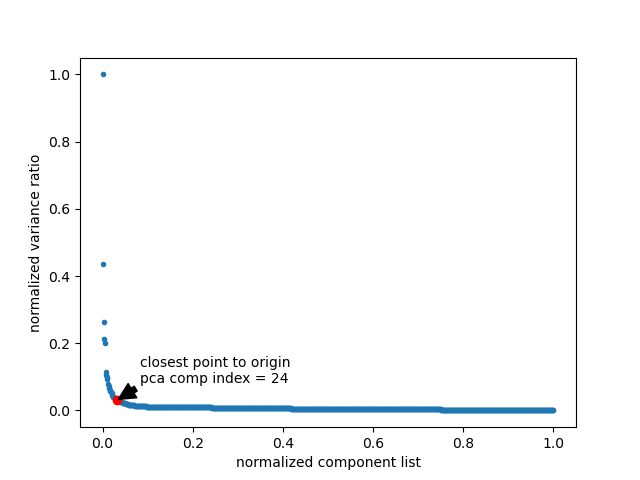

<IPython.core.display.Javascript object>


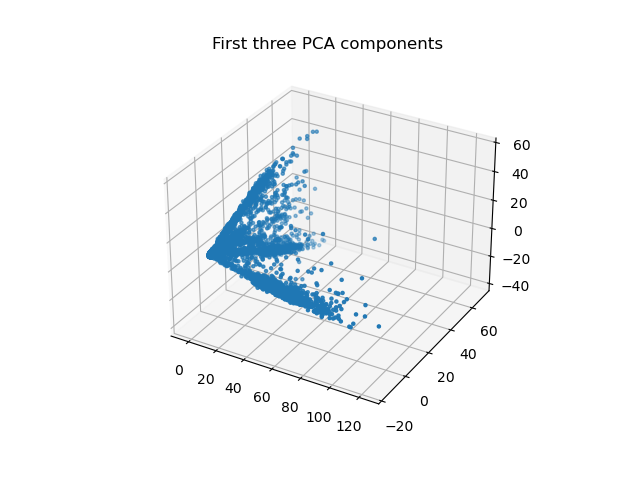

In [31]:
pca_index, arr_pca, status_df = dp.analyze_pca(arr = log_std_arr, 
                                               n_components=log_std_arr.shape[1], 
                                               plot_flag=1, 
                                               status_df=status_df)

In [32]:
arr_pca.shape

(43492, 24)

In [33]:
pca_index

24

In [34]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,NaN
do_tsne,NaN


Amit's method for determining perplexity param - 
1) compute pairwise distance matrix (n_cells x n_cells) from PCA reduced matrix.
2) sort columns by ascending values
3) compute angle from first point to last point of column values from index 1-500
4) use rotation matrix to rotate column values by this angle
5) take argmax for each rotated set of column values and store in list
6) take median of list created in step 5, this is perplexity value



<IPython.core.display.Javascript object>


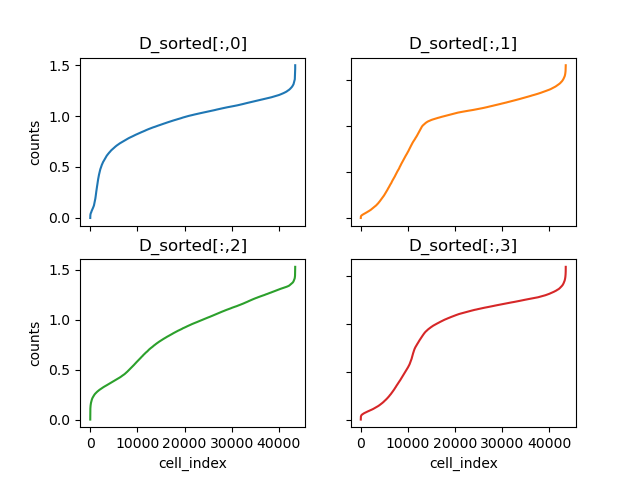

<IPython.core.display.Javascript object>


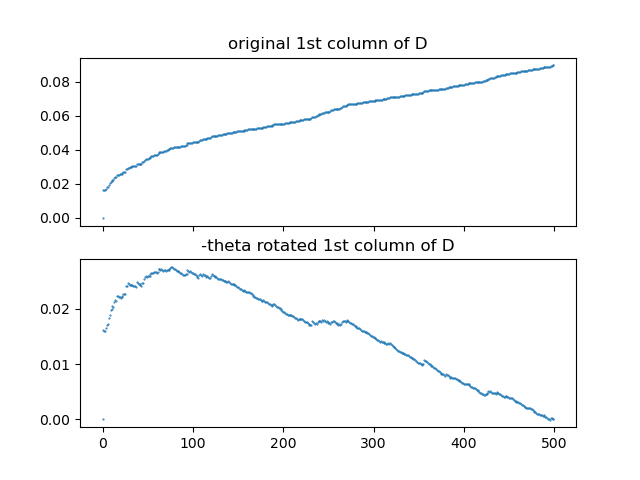

In [35]:
perplexity,status_df = dp.get_perplexity(pca_arr = arr_pca, cutoff=500, plot_flag=1, status_df = status_df)

In [36]:
perplexity

57.0

In [37]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,NaN


#### TSNE on pca reduced matrix using calculated perplexity

creating tsne object with the following parameters: 
n_components:2
n_iter: 1000
learning_rate: 50
early_exaggeration: 12
init: pca
perplexity: 57.0


<IPython.core.display.Javascript object>


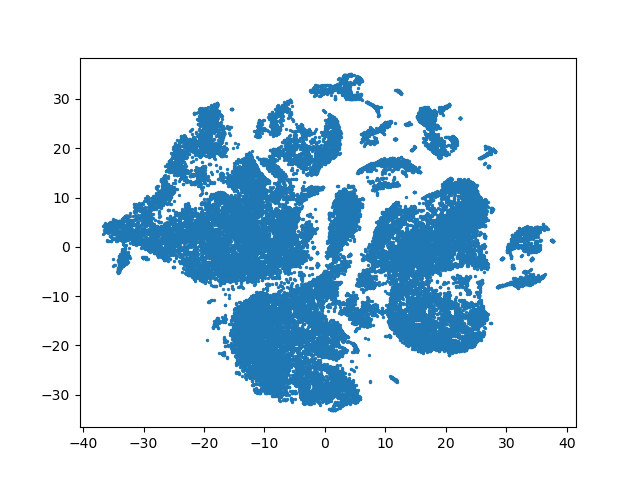

In [38]:
arr_tsne,status_df = dp.do_tsne(arr = arr_pca, 
                               n_components=2,
                               n_iter=1000,
                               learning_rate=50,
                               early_exaggeration=12,
                               init='pca', 
                               perplexity = perplexity,
                               status_df = status_df)

In [39]:
arr_tsne.shape

(43492, 2)

In [40]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,True
